# Word2Vec on declensions corpora
© Francisco Javier Oviamionayi, 2017

Using handmade corpora of Basque declensions

## 0. Dependencies

In [1]:
import glob                          # Finding pathnames matching a pattern
import os                            # Accessing the filesystem
import multiprocessing               # Concurrency
import gensim.models.word2vec as w2v # Word2Vec
import sklearn.manifold              # Dimensionality reduction
import pandas as pd                  # Plotting data
import seaborn as sns                # Visualization

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Input data

In [2]:
# 1.1 DEFINE FILES FOR INPUT DATA
#
# Input data will be a txt file, where each line contains a declensed word and associated data:
# undeclensed_word, declensed_word, grammatic_cases
# (grammatic cases are keywords with # prefix: such as #genitive, #comitative, etc)
# The language I'm using is Basque, for which I think declension vectorization is very useful, since:
#  - It makes extensive use of declensions
#  - It is an ergative language, which means getting declensions right is even more critical
#  - Additionally, different declensions overlap, so context is already needed for disambiguation among overlapping
#    declensed words. This makes it very difficult for statistical translation to get declensions right using context alone
#  - Basque is not widely used, which makes it more difficult to get large corpora for training
declensions_txt_files = sorted(glob.glob("data/declensions.eus.txt"))
# Will get data from the following files
print("Will get data from the following files:")
print(declensions_txt_files)

Will get data from the following files:
['data/declensions.eus.txt']


In [3]:
# 1.2 PREPROCESS INPUT DATA

def read_raw_sentences_from_txt_files(filepaths):
    for filepath in filepaths:
        with open(filepath, 'r') as file:
            for line in filter(lambda line: len(line)>0, map(lambda line: line.rstrip(), file)):
                yield line
                
# Get all the raw sentences from the input files
raw_sentences = read_raw_sentences_from_txt_files(declensions_txt_files)
# Convert each line into a list of words (we will call each list of words a "sentence")
sentences = map(lambda line: line.split(' '), raw_sentences)
# We convert the lazy iterator into a list
sentences = list(sentences)
# Count lines and words
sentence_count = len(sentences)
word_count = sum([len(sentence) for sentence in sentences])
print('We have {0} sentences and {1} words'.format(sentence_count, word_count))
# Print an example
for sentence in sentences[:4]:
    print(sentence)
# The sentences are somwhat unique, with no repeated declensions, but we want Word2Vec to take them into consideration
# so we replicate them
sentences = sentences*10

We have 28 sentences and 86 words
['ni', 'ni', '#absolutive']
['ni', 'nik', '#ergative']
['ni', 'niri', '#dative']
['ni', 'nire', '#genitive']


The text corpora we are using contains the pronouns and their possible declensions, where each line takes the following format of the sentences is:

undeclensed_pronoun declensed_pronoun grammatical_case_tags

This kind of corpora is a sort of tagged corpora (where the tags refer to grammatical cases). Tagged corpora is not a new concept, as it was used in the 1960s' Brown Corpus (https://en.wikipedia.org/wiki/Brown_Corpus) by Brown University in order to implement Part-of-speech tagging. In this experiment we are applying grammatic case tags as additional inputs for modern vector embedding Word2Vec algorithm.

Note that we are not trying to implement Part-of-speech tagging itself, but just to include grammatic-case info into the embedding vectors, so they will contain much more information (dimensions that are specific to declensions), which can subsequently be used by a neural network to implement not only Part-of-speech tagging but any Natural Language Processing task.

## 2. Building our Word2Vec model

In [4]:
# 2. BUILD OUR WORD2VEC MODEL

# Hyperparameters for Word2Vec
num_features = 11                         # Dimensionality of the resulting word vectors.
min_word_count = 3                        # Minimum word count threshold.
num_workers = multiprocessing.cpu_count() # Number of threads to run in parallel.
context_size = 3                          # Context window length.
downsampling = 0                          # Downsample setting for frequent words.
seed = 1                                  # Seed for the RNG, to make the results reproducible.
# Now we create the model
w2v_model = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

## 3. Training the model

In [5]:
# 3.1 BUILDING VOCABULARY
w2v_model.build_vocab(sentences)
print("Word2Vec vocabulary length: ", len(w2v_model.wv.vocab))

Word2Vec vocabulary length:  33


In [6]:
# 3.2 TRAINING THE MODEL
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
#w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=15)

4300

In [7]:
# 3.3 SAVING THE MODEL
if not os.path.exists("trained"):
    os.makedirs("trained")
w2v_model.save(os.path.join("trained", "w2v_model.w2v"))

## 4. Testing the model

In [8]:
# 4.1 LOADING THE MODEL
w2v_model = w2v.Word2Vec.load(os.path.join("trained", "w2v_model.w2v"))

In [9]:
# 4.2 Squash dimensionality to 2
# https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [10]:
# 4.3 Put it all into a giant matrix
all_word_vectors_matrix = w2v_model.wv.syn0

In [11]:
# 4.4 Train t-SNE
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [12]:
# 4.5 Defining points to plot in 2D space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[w2v_model.wv.vocab[word].index])
            for word in w2v_model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [13]:
# 4.6 Let's have a look at the points in 2D space
points.head(10)

,word,x,y
0,#absolutive,-96.429955,73.790742
1,hark,62.888025,-17.233820
2,guk,-41.326415,-49.667168
3,#ergative,-44.177453,-93.643874
4,zuek,116.623339,67.891412
5,ni,17.004602,117.800249
6,#dative,-73.840569,-25.028538
7,haiek,81.123576,20.585871
8,zuri,50.603756,90.145565
9,nire,29.325708,-87.401940


In [14]:
# 4.7 Configuring Seaborn plotting
sns.set_context("poster")

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


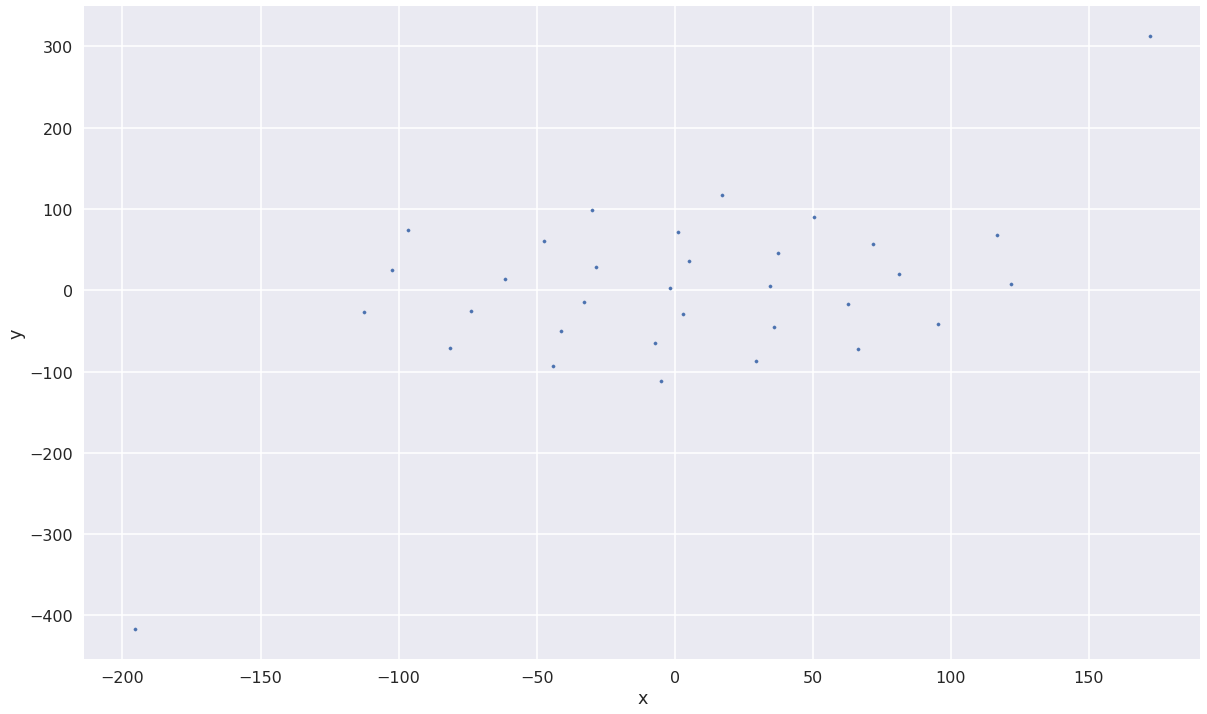

In [15]:
# 4.8 Let's have a look at all the vectors
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [16]:
# 4.9 Defining a function to plot not all the vector space but just a region
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


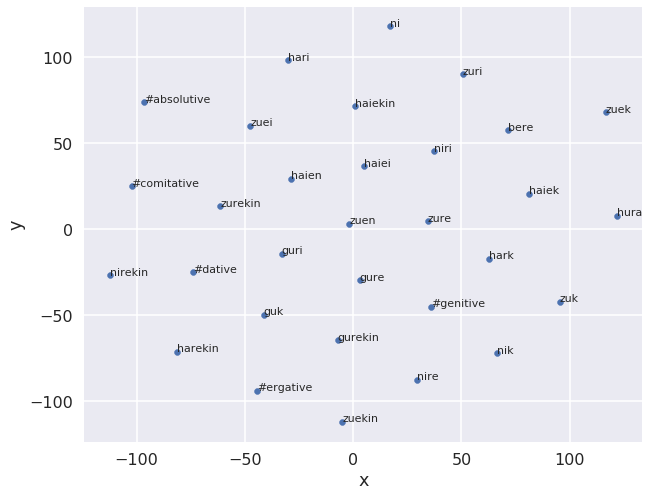

In [17]:
# 4.10. Let's have a look at most of the embedding vectors.
# As we will see, the neighbouring words are related through either common declension or same pronoun (but different declension)
plot_region(x_bounds=(-200, 200), y_bounds=(-200, 200))

In [18]:
# 4.11 Similarities for "zuk". First 6 ones share either the same pronoun or the same grammatical case. Good!
w2v_model.most_similar("zuk")

[('nik', 0.9683747291564941),
 ('zure', 0.9663078784942627),
 ('zurekin', 0.9598204493522644),
 ('zuri', 0.9577801823616028),
 ('guk', 0.9576573371887207),
 ('hark', 0.9459083080291748),
 ('haiekin', 0.9312465786933899),
 ('nirekin', 0.9150515794754028),
 ('niri', 0.9114317893981934),
 ('nire', 0.9082954525947571)]

In [19]:
# 4.12 Similarities for "gurekin". 1st to 3rd and 5th to 7th share either the same pronoun or the same grammatical case. Not bad
w2v_model.most_similar("gurekin")

[('guri', 0.980905294418335),
 ('gure', 0.9693418741226196),
 ('guk', 0.963940441608429),
 ('zuei', 0.9604324102401733),
 ('haiekin', 0.9585168361663818),
 ('zuekin', 0.9552578330039978),
 ('zurekin', 0.9530965089797974),
 ('zuen', 0.9360567331314087),
 ('harekin', 0.9347277879714966),
 ('zuri', 0.9315460920333862)]

In [20]:
# 4.13 Defining a function to test relationships
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = w2v_model.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [21]:
# 4.14 Testing relationships across different dimensions. 5 tests, all correct but the 4th one. Quite decent
nearest_similarity_cosmul("nik", "ni", "zu")
nearest_similarity_cosmul("hura", "hark", "nik")
nearest_similarity_cosmul("gure", "zure", "zuri")
nearest_similarity_cosmul("zu", "gu", "gurekin")
nearest_similarity_cosmul("haiekin", "haien", "zure")

nik is related to ni, as zuk is related to zu
hura is related to hark, as ni is related to nik
gure is related to zure, as guri is related to zuri
zu is related to gu, as zure is related to gurekin
haiekin is related to haien, as zurekin is related to zure


'zurekin'

In [22]:
# 4.15 One more test with  3rd person of plural, in which different declensions overlap
#  so our word vectorization could be confused. But working this time!
nearest_similarity_cosmul("haiei", "haiek", "zu")

haiei is related to haiek, as zuri is related to zu


'zuri'